# Section 5: deep reinforcement learning with the openai gym

### Installing the OpenAI gym
There are multiple ways you can install the OpenAI gym environment. 
##### In our Docker image
It is already installed in our Docker image. This means you don't have to do anything to include it, and you can start playing immediately. The downside of this is that there is no screen attached to our Docker image, which gives a bit of hassle inline. 
##### On your own pc. 
If you do want to see a screen with your game you would have to install everything locally. This means you have your own version of Python, TensorFlow, Matplotlib, etc. installed. If this is all fine you can install the OpenAI gym with this command. 

For more information: see [this site](https://github.com/openai/gym#installing-everything). 

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

from ipywidgets import widgets
from IPython.display import display

import gym

## Set logging dir for Tensorboard
logging_dir_n = 141


In [ ]:
env = gym.make('CartPole-v0')
observation = env.reset()
firstframe = env.render(mode = 'rgb_array')
fig,ax = plt.subplots()
im = ax.imshow(firstframe) 


In [ ]:
observation, reward, done, info = env.step(0)
frame = env.render(mode = 'rgb_array')
plt.imshow(frame)
plt.show()

### Random actions
With the function `env.action_space.sample()` you get a random action that's possible for this action space. Please take some time to figure out what kind of commands are possible, and what env.step does. 

In [ ]:
observation = env.reset()
for _ in range(100):
    frame = env.render(mode = 'rgb_array')
    plt.imshow(frame)
    plt.show()
    observation, reward, done, info = env.step(env.action_space.sample()) 

### Input to our algorithm
Let's explore the input we can use for our algorithm: 


In [ ]:
frame = env.render(mode = 'rgb_array')
plt.imshow(frame)
plt.show()

observation, reward, done, info = env.step(env.action_space.sample()) 
print(observation)
print(reward)
print(done)
print(info)

observation = env.reset()

frame = env.render(mode = 'rgb_array')
plt.imshow(frame)
plt.show()

observation, reward, done, info = env.step(env.action_space.sample()) 
print(observation)
print(reward)
print(done)
print(info)


##### Input
The input consists of the angle of the pole, turn velocity of the pole, the location of the base, and the movespeed of the base. Other environments have different inputs. Some environments (the Atari games) simply give you an image, other environments give a representation of the state. 

##### Reward
Reward is the reward our environment gives us each frame. For cartpole the reward is 1.0 while we managed to keep the stick in less than a small angle. After we reached this angle the reward will change to 0.0 while we did not reset the environment. 

Other environments give different rewards. Mountaincar for example gives a reward of 0.0 while we did not reach the top, and 1.0 once we reached it. Whenever you try a new environment make sure you know when your algorithm receives a reward as this is vital for learning something. 

##### Done
If this boolean is True it means you probably want to reset your network. In the case of cartpole it means the cart can't get anymore points: either by:
- failing to keep the pole at less than a certain angle
- failing to keep the base at less than a certain distance
- succeeding at this for more than 200 frames!

Other environments end when your lives are gone, others end after a certain amount of iterations.

In [ ]:
observation = env.reset()
for _ in range(250):
    frame = env.render(mode = 'rgb_array')
    plt.imshow(frame)
    plt.show()
    observation, reward, done, info = env.step(env.action_space.sample()) 
    
    if done:
        print("Done = true!")
        observation = env.reset()

#### Playing yourself
Now you are able to play a pretty boring game with a text-interface...

In [ ]:
# observation = env.reset()
# done = False
# while not done:
#     frame = env.render(mode = 'rgb_array')
#     plt.imshow(frame)
#     plt.show()
    
#     useraction = -1
#     while useraction < 0:
#         try:
#             useraction = int(input("Left (0) or right (1)?"))
#         except:
#             pass
        
        
#     observation, reward, done, info = env.step(useraction) 
# print("You are dead..")

## Video 2: Random search. Solving your first problem, and joining the leaderboard
http://kvfrans.com/simple-algoritms-for-solving-cartpole/



## Video 3: Reinforcement learning explained: approximating the value function
![reward fucntion](http://www.pinchofintelligence.com/wp-content/uploads/2017/07/rewardfunction.png)

In [ ]:
tf.reset_default_graph()
networkstate = tf.placeholder(tf.float32, [None, 4], name="input")
networkaction = tf.placeholder(tf.int32, [None], name="actioninput")
networkreward = tf.placeholder(tf.float32,[None], name="groundtruth_reward")

layer1 = tf.layers.dense(networkstate, 16, activation=tf.nn.relu, name="dense1")
layer2 = tf.layers.dense(layer1, 32, activation=tf.nn.relu, name="dense2")
layer3 = tf.layers.dense(layer2, 8, activation=tf.nn.relu, name="dense3")
predictedreward = tf.layers.dense(layer3, 2, name="dense4")


In [ ]:
with tf.name_scope("lossdeterminer"):
    action_onehot = tf.one_hot(networkaction, 2, name="actiononehot")
    qreward = tf.reduce_sum(tf.multiply(predictedreward, action_onehot), reduction_indices = 1)
    loss = tf.reduce_mean(tf.square(networkreward - qreward))

tf.summary.scalar('loss', loss)
tf.summary.scalar('mean_max_reward', tf.reduce_max(predictedreward))

#optimizer = tf.train.AdamOptimizer().minimize(loss)
optimizer = tf.train.RMSPropOptimizer(0.01).minimize(loss)
merged_summary = tf.summary.merge_all()


In [ ]:
sess = tf.InteractiveSession()
summary_writer = tf.summary.FileWriter('graphs/dqn/normal/'+str(logging_dir_n),sess.graph)
logging_dir_n +=1
sess.run(tf.global_variables_initializer())


### Setting hyperparameters

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.9
MAX_LEN_REPLAY_MEMORY = 10000 # replay memory of one million most recent frames.
FRAMES_TO_PLAY = 50001
MIN_FRAMES_FOR_LEARNING = 1000

### Training

In [ ]:
def learn(replay_memory):
      ### Learn once we have enough frames to start learning
    if len(replay_memory) > MIN_FRAMES_FOR_LEARNING: 
        experiences = random.sample(replay_memory, BATCH_SIZE)
        totrain = [] # (state, action, delayed_reward)
        
        ### Calculate the predicted reward
        nextstates = [var[4] for var in experiences]
        pred_reward = sess.run(predictedreward, feed_dict={networkstate:nextstates})
        
        ### Set the "ground truth": the value our network has to predict:
        for index in range(BATCH_SIZE):
            state, action, reward, terminalstate, newstate = experiences[index]
            predicted_reward = max(pred_reward[index])
            
            if terminalstate:
                delayedreward = reward
            else:
                delayedreward = reward + GAMMA*predicted_reward
            totrain.append((state, action, delayedreward))
            
        ### Feed the train batch to the algorithm 
        states = [var[0] for var in totrain]
        actions = [var[1] for var in totrain]
        rewards = [var[2] for var in totrain]
        _, l, summary = sess.run([optimizer, loss, merged_summary], feed_dict={networkstate:states, networkaction: actions, networkreward: rewards})


        ### If our memory is too big: remove the first element
        if len(replay_memory) > MAX_LEN_REPLAY_MEMORY:
                replay_memory = replay_memory[1:]

        ### Show the progress 
        summary_writer.add_summary(summary, i_epoch)

  

### Running this in our environment

In [ ]:
replay_memory = [] # (state, action, reward, terminalstate, state_t+1)

for i_epoch in range(FRAMES_TO_PLAY):
    
    ### Select an action and perform this
    action = env.action_space.sample() 
    newobservation, reward, terminal, info = env.step(action)

    ### I prefer that my agent gets 0 reward if it dies
    if terminal: 
        reward = 0
        
    ### Add the observation to our replay memory
    replay_memory.append((observation, action, reward, terminal, newobservation))
    
    ### Reset the environment if the agent died
    if terminal: 
        newobservation = env.reset()
    observation = newobservation
    
    learn(replay_memory)
    

### Now test this

RUN pip install git+https://github.com/jakevdp/JSAnimation.git

Use imagemagick, 



In [ ]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

def display_frames_as_gif(frames, filename_gif = None):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename_gif: 
        anim.save(filename_gif, writer = 'imagemagick', fps=20)
    display(display_animation(anim, default_mode='loop'))


In [ ]:
observation = env.reset()
term = False
predicted_q = []
frames = []

### Play till we are dead
while not term:
    rgb_observation = env.render(mode = 'rgb_array')
    frames.append(rgb_observation)
    pred_q = sess.run(predictedreward, feed_dict={networkstate:[observation]})
    predicted_q.append(pred_q)
    action = np.argmax(pred_q)
    observation, _, term, _ = env.step(action)

### Plot the replay!
print("Frames: " + str(len(frames)))
display_frames_as_gif(frames,filename_gif='dqn_run.gif')

### Reinforcement learning tricks


In [ ]:
sess = tf.InteractiveSession()
summary_writer = tf.summary.FileWriter('graphs/dqn/normal/'+str(logging_dir_n),sess.graph)
logging_dir_n +=1
sess.run(tf.global_variables_initializer())

In [ ]:
replay_memory = [] # (state, action, reward, terminalstate, state_t+1)
epsilon = 1.0
decay_factor = 0.001
MIN_EPSILON = 0.1

observation = env.reset()

for i_epoch in range(FRAMES_TO_PLAY):
    
    ### Select action
    if random.random() < epsilon:
        action = env.action_space.sample() 
    else:
        pred_q = sess.run(predictedreward, feed_dict={networkstate:[observation]})
        action = np.argmax(pred_q)
    
    ### Anneal epsilon
    epsilon = max(epsilon-decay_factor, MIN_EPSILON)
    
    newobservation, reward, terminal, info = env.step(action)
    ### I prefer that my agent gets 0 reward if it dies
    if terminal: 
        reward = 0
        
    ### Add the observation to our replay memory
    replay_memory.append((observation, action, reward, terminal, newobservation))
    
    ### Reset the environment if the agent died
    if terminal: 
        newobservation = env.reset()
    observation = newobservation
    
    learn(replay_memory)

In [ ]:
observation = env.reset()
term = False
predicted_q = []
frames = []

### Play till we are dead
while not term:
    rgb_observation = env.render(mode = 'rgb_array')
    frames.append(rgb_observation)
    pred_q = sess.run(predictedreward, feed_dict={networkstate:[observation]})
    predicted_q.append(pred_q)
    action = np.argmax(pred_q)
    observation, _, term, _ = env.step(action)

### Plot the replay!
print("Frames: " + str(len(frames)))
display_frames_as_gif(frames,filename_gif='dqn_run.gif')

## Video 4: Remembering your actions: adding a replay memory


## Video 5: Introduction to the Atari environment


(210, 160, 3)
0


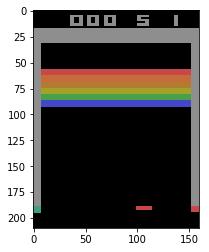

3


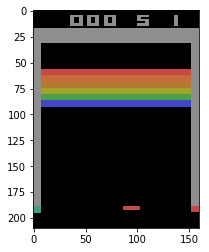

1


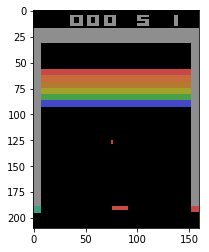

0


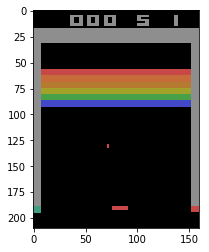

3


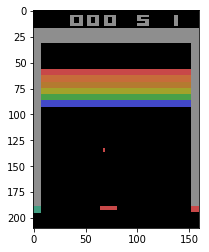

3


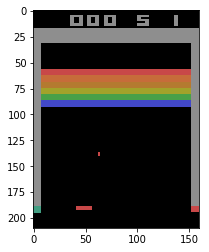

3


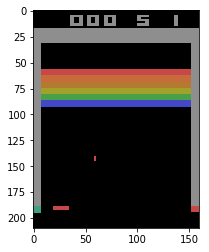

3


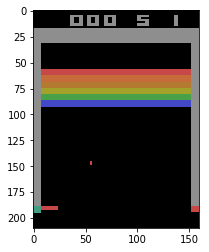

1


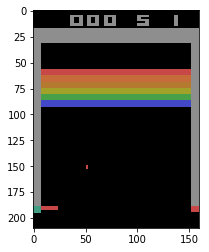

3


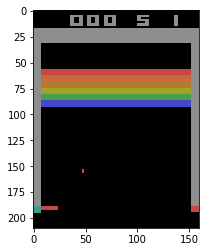

1


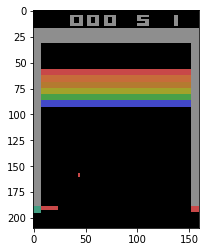

2


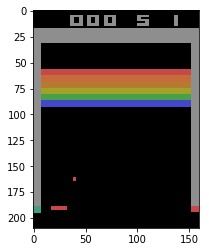

0


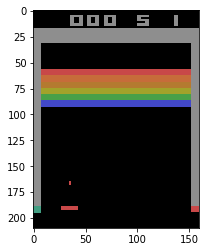

3


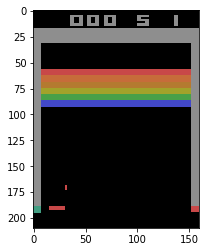

2


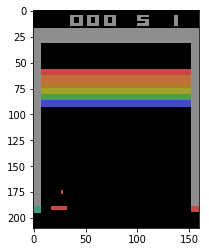

0


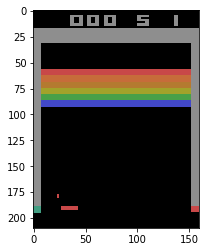

0


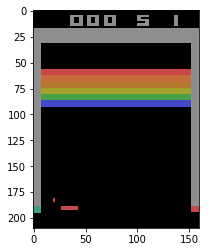

0


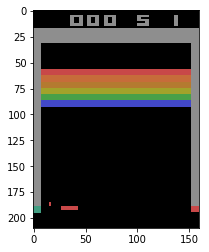

2


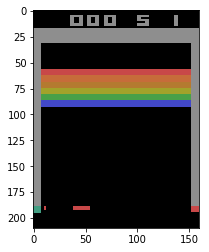

1


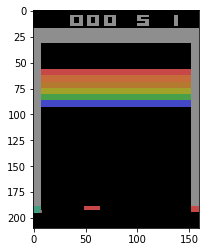

2


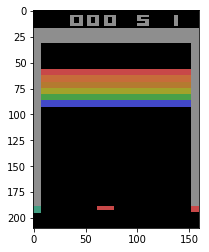

3


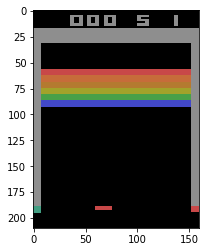

3


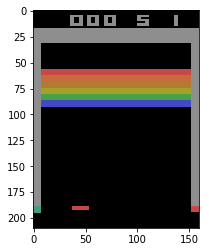

2


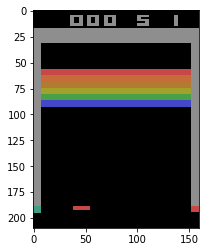

0


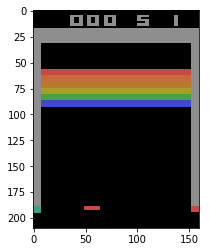

1


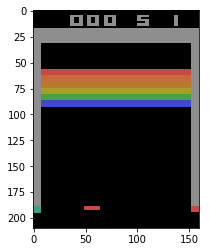

1


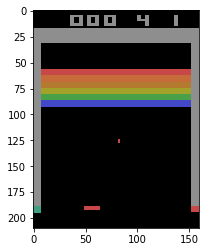

1


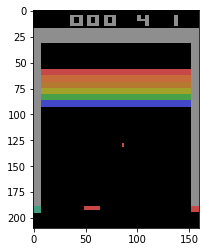

1


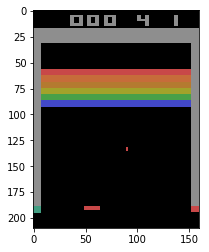

0


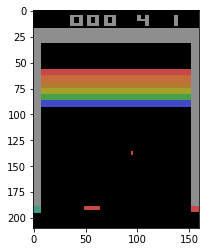

1


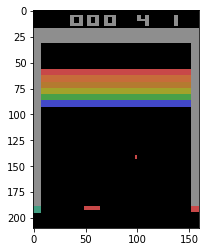

0


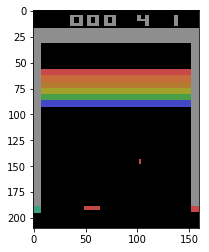

3


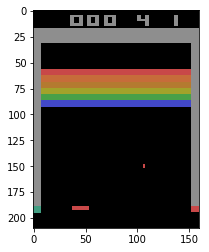

0


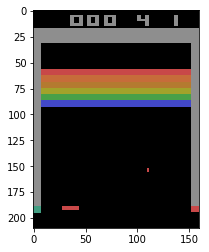

3


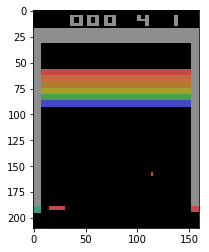

1


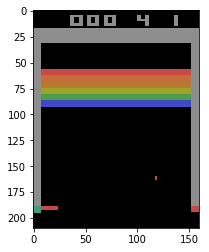

2


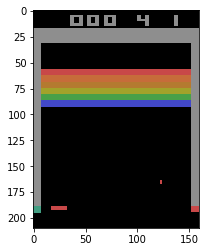

3


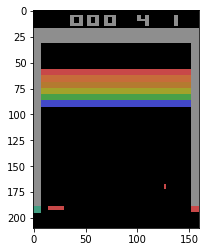

3


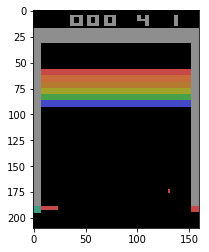

0


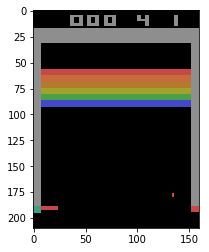

2


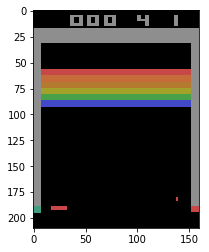

3


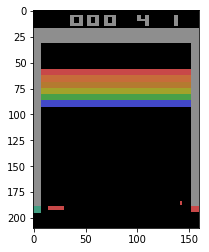

0


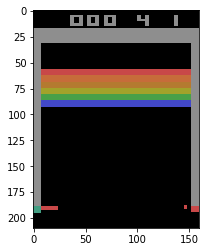

1


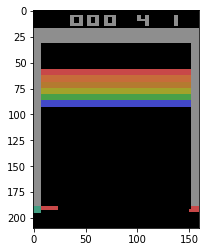

3


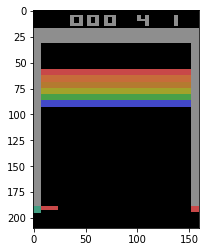

1


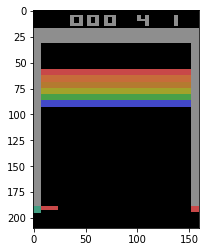

3


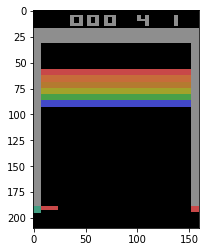

3


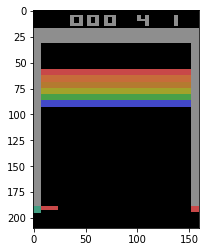

2


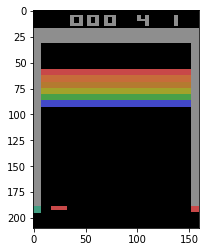

3


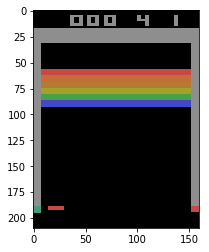

0


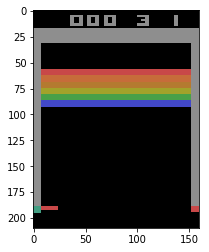

1


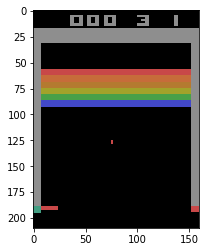

1


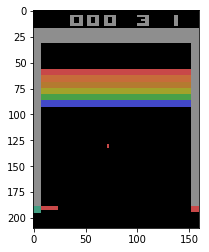

1


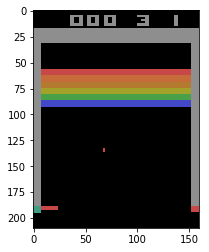

3


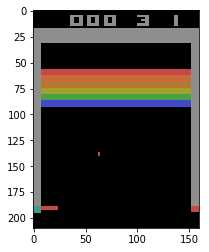

0


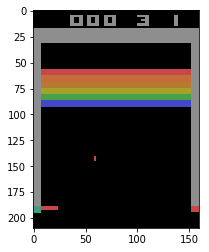

3


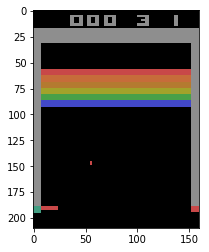

2


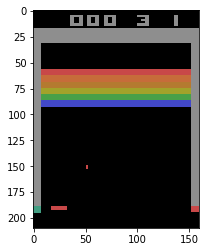

0


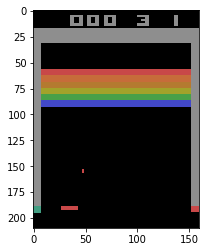

3


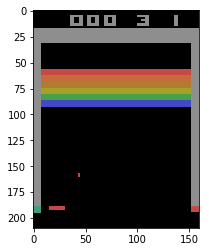

3


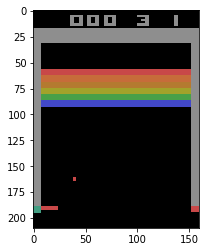

2


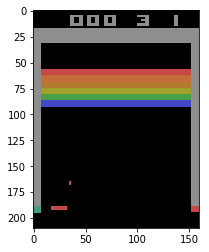

3


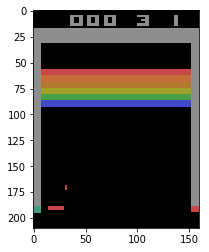

2


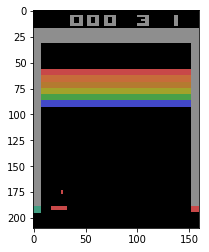

3


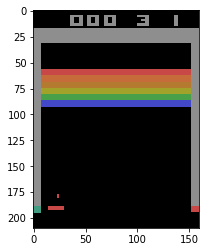

0


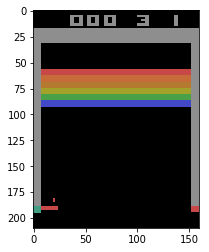

2


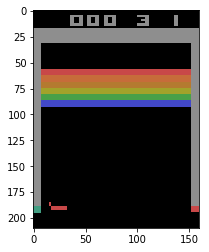

0


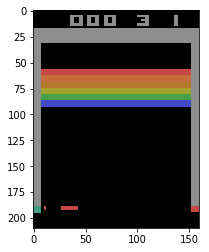

0


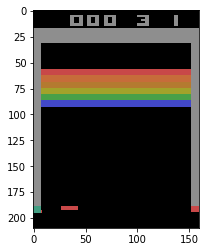

0


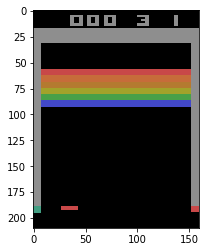

1


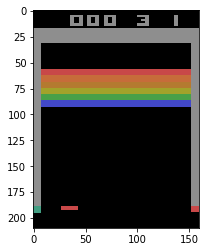

1


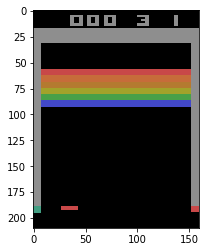

2


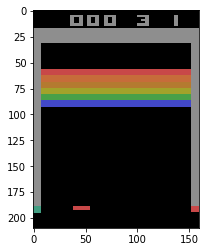

0


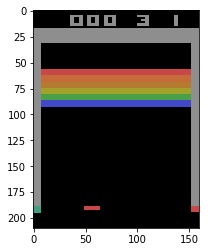

0


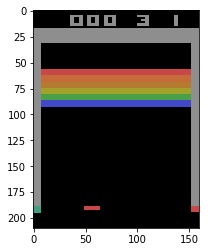

1


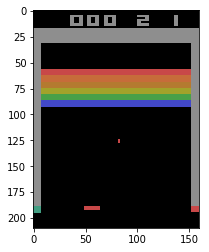

3


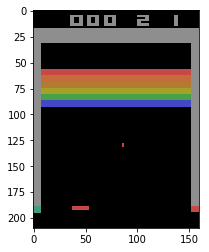

0


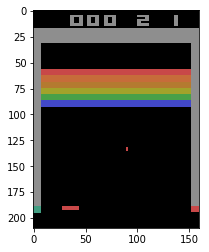

1


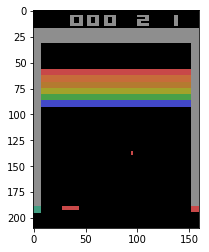

2


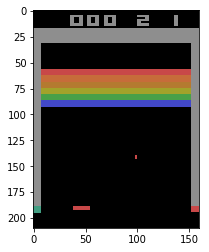

2


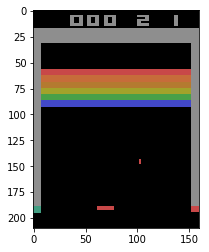

3


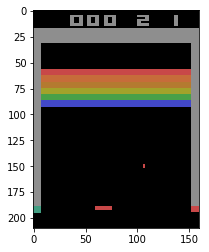

0


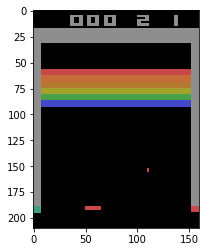

1


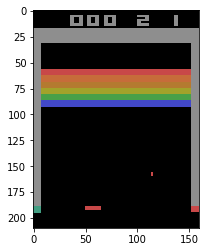

1


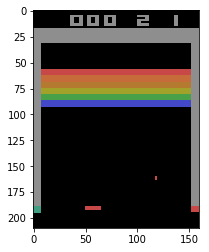

3


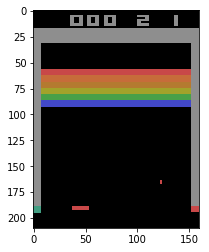

1


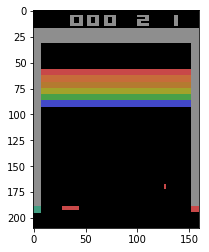

1


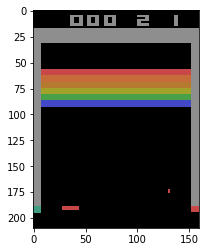

3


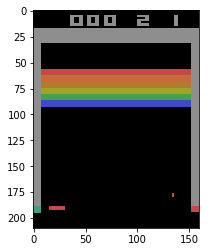

2


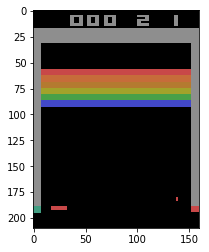

3


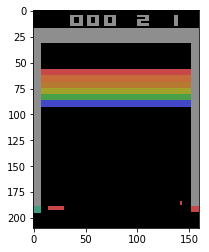

3


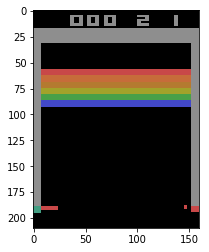

2


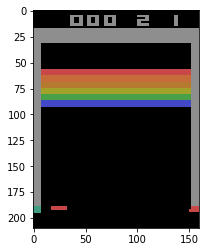

2


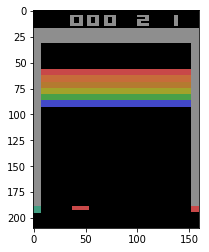

3


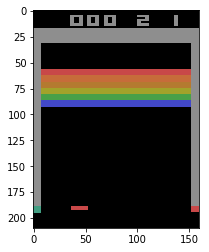

0


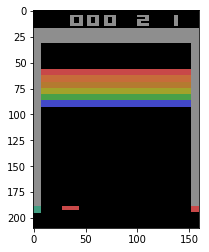

2


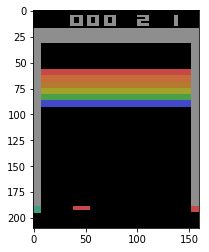

3


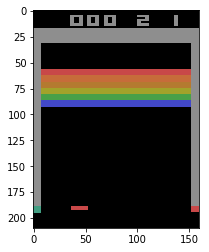

1


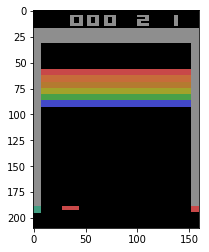

0


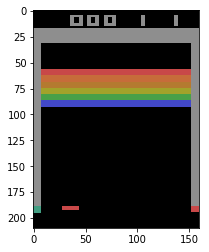

In [2]:
env = gym.make("BreakoutDeterministic-v4")
observation = env.reset()
print(observation.shape)
plt.imshow(observation)

observation = env.reset()
for _ in range(10):
    action = env.action_space.sample()
    print(action)
    observation, reward, done, info = env.step(action) 
    plt.imshow(observation)
    plt.show()



In [3]:
observation.shape

(210, 160, 3)

https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [4]:
env.action_space.n

4

In [5]:
def huber_loss(x, delta=1.0):
    """Reference: https://en.wikipedia.org/wiki/Huber_loss"""
    return tf.where(
        tf.abs(x) < delta,
        tf.square(x) * 0.5,
        delta * (tf.abs(x) - 0.5 * delta)
    )

def scope_vars(scope, trainable_only=False):
    """
    Get variables inside a scope
    The scope can be specified as a string
    Parameters
    ----------
    scope: str or VariableScope
        scope in which the variables reside.
    trainable_only: bool
        whether or not to return only the variables that were marked as trainable.
    Returns
    -------
    vars: [tf.Variable]
        list of variables in `scope`.
    """
    return tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES if trainable_only else tf.GraphKeys.GLOBAL_VARIABLES,
        scope=scope if isinstance(scope, str) else scope.name
    )

def scope_name():
    """Returns the name of current scope as a string, e.g. deepq/q_func"""
    return tf.get_variable_scope().name

def absolute_scope_name(relative_scope_name):
    """Appends parent scope name to `relative_scope_name`"""
    return scope_name() + "/" + relative_scope_name


def function(inputs, outputs, updates=None, givens=None):
    """Just like Theano function. Take a bunch of tensorflow placeholders and expressions
    computed based on those placeholders and produces f(inputs) -> outputs. Function f takes
    values to be fed to the input's placeholders and produces the values of the expressions
    in outputs.
    Input values can be passed in the same order as inputs or can be provided as kwargs based
    on placeholder name (passed to constructor or accessible via placeholder.op.name).
    Example:
        x = tf.placeholder(tf.int32, (), name="x")
        y = tf.placeholder(tf.int32, (), name="y")
        z = 3 * x + 2 * y
        lin = function([x, y], z, givens={y: 0})
        with single_threaded_session():
            initialize()
            assert lin(2) == 6
            assert lin(x=3) == 9
            assert lin(2, 2) == 10
            assert lin(x=2, y=3) == 12
    Parameters
    ----------
    inputs: [tf.placeholder or TfInput]
        list of input arguments
    outputs: [tf.Variable] or tf.Variable
        list of outputs or a single output to be returned from function. Returned
        value will also have the same shape.
    """
    if isinstance(outputs, list):
        return _Function(inputs, outputs, updates, givens=givens)
    elif isinstance(outputs, (dict, collections.OrderedDict)):
        f = _Function(inputs, outputs.values(), updates, givens=givens)
        return lambda *args, **kwargs: type(outputs)(zip(outputs.keys(), f(*args, **kwargs)))
    else:
        f = _Function(inputs, [outputs], updates, givens=givens)
        return lambda *args, **kwargs: f(*args, **kwargs)[0]

class _Function(object):
    def __init__(self, inputs, outputs, updates, givens, check_nan=False):
        for inpt in inputs:
            if not issubclass(type(inpt), TfInput):
                assert len(inpt.op.inputs) == 0, "inputs should all be placeholders of baselines.common.TfInput"
        self.inputs = inputs
        updates = updates or []
        self.update_group = tf.group(*updates)
        self.outputs_update = list(outputs) + [self.update_group]
        self.givens = {} if givens is None else givens
        self.check_nan = check_nan

    def _feed_input(self, feed_dict, inpt, value):
        if issubclass(type(inpt), TfInput):
            feed_dict.update(inpt.make_feed_dict(value))
        elif is_placeholder(inpt):
            feed_dict[inpt] = value

    def __call__(self, *args, **kwargs):
        assert len(args) <= len(self.inputs), "Too many arguments provided"
        feed_dict = {}
        # Update the args
        for inpt, value in zip(self.inputs, args):
            self._feed_input(feed_dict, inpt, value)
        # Update the kwargs
        kwargs_passed_inpt_names = set()
        for inpt in self.inputs[len(args):]:
            inpt_name = inpt.name.split(':')[0]
            inpt_name = inpt_name.split('/')[-1]
            assert inpt_name not in kwargs_passed_inpt_names, \
                "this function has two arguments with the same name \"{}\", so kwargs cannot be used.".format(inpt_name)
            if inpt_name in kwargs:
                kwargs_passed_inpt_names.add(inpt_name)
                self._feed_input(feed_dict, inpt, kwargs.pop(inpt_name))
            else:
                assert inpt in self.givens, "Missing argument " + inpt_name
        assert len(kwargs) == 0, "Function got extra arguments " + str(list(kwargs.keys()))
        # Update feed dict with givens.
        for inpt in self.givens:
            feed_dict[inpt] = feed_dict.get(inpt, self.givens[inpt])
        results = get_session().run(self.outputs_update, feed_dict=feed_dict)[:-1]
        if self.check_nan:
            if any(np.isnan(r).any() for r in results):
                raise RuntimeError("Nan detected")
        return results

def mem_friendly_function(nondata_inputs, data_inputs, outputs, batch_size):
    if isinstance(outputs, list):
        return _MemFriendlyFunction(nondata_inputs, data_inputs, outputs, batch_size)
    else:
        f = _MemFriendlyFunction(nondata_inputs, data_inputs, [outputs], batch_size)
        return lambda *inputs: f(*inputs)[0]

class _MemFriendlyFunction(object):
    def __init__(self, nondata_inputs, data_inputs, outputs, batch_size):
        self.nondata_inputs = nondata_inputs
        self.data_inputs = data_inputs
        self.outputs = list(outputs)
        self.batch_size = batch_size

    def __call__(self, *inputvals):
        assert len(inputvals) == len(self.nondata_inputs) + len(self.data_inputs)
        nondata_vals = inputvals[0:len(self.nondata_inputs)]
        data_vals = inputvals[len(self.nondata_inputs):]
        feed_dict = dict(zip(self.nondata_inputs, nondata_vals))
        n = data_vals[0].shape[0]
        for v in data_vals[1:]:
            assert v.shape[0] == n
        for i_start in range(0, n, self.batch_size):
            slice_vals = [v[i_start:builtins.min(i_start + self.batch_size, n)] for v in data_vals]
            for (var, val) in zip(self.data_inputs, slice_vals):
                feed_dict[var] = val
            results = tf.get_default_session().run(self.outputs, feed_dict=feed_dict)
            if i_start == 0:
                sum_results = results
            else:
                for i in range(len(results)):
                    sum_results[i] = sum_results[i] + results[i]
        for i in range(len(results)):
            sum_results[i] = sum_results[i] / n
        return sum_results


In [6]:
GAMMA = 0.99

tf.reset_default_graph()
global_step = tf.Variable(0, trainable=False)

networkstate = tf.placeholder(tf.float32, [None, 84, 84, 4], name="input")
nextnetworkstate = tf.placeholder(tf.float32, [None, 84, 84, 4], name="inputnext")
networkaction = tf.placeholder(tf.int32, [None], name="actioninput")
networkreward = tf.placeholder(tf.float32, [None], name="actioninput")
done_mask_ph = tf.placeholder(tf.float32, [None], name="done")


inputimage = networkstate/255
nextnetworkstate = nextnetworkstate/255
# inputimage = tf.image.resize_images(inputimage, (84, 84))

#tf.summary.image("inputimage", inputimage)

def build_network(namescope, input_for_network):
    with tf.variable_scope(namescope):
        layer1 = tf.layers.conv2d(inputimage, 32, [8,8], activation=tf.nn.relu, strides=(4, 4), name="conv1", padding='same')
        layer2 = tf.layers.conv2d(layer1, 64, [4,4], strides=(2,2), activation=tf.nn.relu, name="conv2", padding='same')
        layer3 = tf.layers.conv2d(layer2, 64, [3,3], activation=tf.nn.relu, name="conv3", padding="same")
        flattened = tf.contrib.layers.flatten(layer3)

        flat2 = tf.layers.dense(flattened, 256, activation=tf.nn.relu, name="dense2")
        predictedreward = tf.layers.dense(flat2, env.action_space.n, name="dense3")
    return predictedreward

predicted_action = build_network("actionnetwork", inputimage)
#q_func_vars = scope_vars(absolute_scope_name("actionnetwork"))
q_func_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "actionnetwork")
assert len(q_func_vars) > 0

predicted_value = build_network("valuenetwork", nextnetworkstate)
#target_q_func_vars = scope_vars(absolute_scope_name("valuenetwork"))
target_q_func_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "valuenetwork")
assert len(target_q_func_vars) > 0

with tf.name_scope("lossdeterminer"):
    action_onehot = tf.one_hot(networkaction, env.action_space.n, name="actiononehot")
    predicted_qreward = tf.reduce_sum(tf.multiply(predicted_action, action_onehot), reduction_indices = 1)
    ## TODO: Do I want to set estimated reward to zero if the agent was done in this frame?
    estimated_reward = tf.reduce_max(predicted_value)

    q_tp1_best_masked = (1.0 - done_mask_ph) * estimated_reward

    q_t_selected_target = networkreward + GAMMA * q_tp1_best_masked
    td_error = predicted_qreward - tf.stop_gradient(q_t_selected_target)
    loss = huber_loss(td_error)

#     loss = tf.reduce_mean(tf.square(networkreward - qreward))


sum1 = tf.summary.scalar('loss', tf.reduce_sum(loss))
sum2 = tf.summary.scalar('mean_max_reward', tf.reduce_max(predicted_action))
merged_summary = tf.summary.merge([sum1, sum2]) #tf.summary.merge_all()


#optimizer = tf.train.AdamOptimizer().minimize(loss)
#optimizer = tf.train.RMSPropOptimizer(0.001).minimize(loss)
learning_rate_minimum = 0.00015
learning_rate = 0.0025
learning_rate_decay = 0.97
scale = 10000
learning_rate_decay_step = 5 * scale

learning_rate_step = tf.placeholder('int64', None, name='learning_rate_step')
learning_rate_op = tf.maximum(learning_rate_minimum,tf.train.exponential_decay(
      learning_rate,
      global_step,
      learning_rate_decay_step,
      learning_rate_decay,
      staircase=True))

optimizer = tf.train.RMSPropOptimizer(learning_rate_op, momentum=0.97, epsilon=0.001).minimize(loss, global_step=global_step)


mean_last_n_ph = tf.placeholder(tf.float32)
max_last_n_ph = tf.placeholder(tf.float32)
min_last_n_ph = tf.placeholder(tf.float32)
epsilon_ph = tf.placeholder(tf.float32)
sum3 = tf.summary.scalar("mean_last_n",mean_last_n_ph )
sum4 = tf.summary.scalar("max_last_n",max_last_n_ph )
sum5 = tf.summary.scalar("min_last_n",min_last_n_ph )
sum6 = tf.summary.scalar("epsilon",epsilon_ph )
sum7 = tf.summary.scalar("learning_rate",learning_rate_op )
merged_summary_meta = tf.summary.merge([sum3, sum4, sum5, sum6, sum7])

update_target_expr = []
for var, var_target in zip(sorted(q_func_vars, key=lambda v: v.name), sorted(target_q_func_vars, key=lambda v: v.name)):
    update_target_expr.append(var_target.assign(var))
update_target_expr = tf.group(*update_target_expr)
update_target = function([], [], updates=[update_target_expr])



In [7]:
len(q_func_vars)

10

In [8]:
sess = tf.InteractiveSession()
summary_writer = tf.summary.FileWriter('graphs/dqn/atari/'+str(logging_dir_n),sess.graph)
logging_dir_n +=1
sess.run(tf.global_variables_initializer())

In [9]:
import cv2
def preprocess(observation):
    observation = cv2.cvtColor(cv2.resize(observation, (84, 110), interpolation = cv2.INTER_AREA), cv2.COLOR_BGR2GRAY)
    observation = observation[26:110,:]
    ret, observation = cv2.threshold(observation,1,255,cv2.THRESH_BINARY)
    return np.reshape(observation,(84,84,1))




(84, 84, 1)


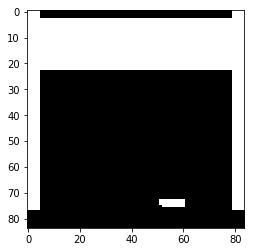

SETTING NETWORK PARAMETERS TO SAME10 0.9999899999999997
Reward this episode: 2.0 epsilon: 0.9996489999999899
Reward this episode: 4.0 epsilon: 0.9982229999999489
SETTING NETWORK PARAMETERS TO SAME10010 0.9899899999997122
SETTING NETWORK PARAMETERS TO SAME20010 0.9799899999994246
Reward this episode: 5.0 epsilon: 0.9723919999992061
Reward this episode: 8.0 epsilon: 0.9702499999991445
SETTING NETWORK PARAMETERS TO SAME30010 0.969989999999137
SETTING NETWORK PARAMETERS TO SAME40010 0.9599899999988495
SETTING NETWORK PARAMETERS TO SAME50010 0.9499899999985619
SETTING NETWORK PARAMETERS TO SAME60010 0.9399899999982744
SETTING NETWORK PARAMETERS TO SAME70010 0.9299899999979868
SETTING NETWORK PARAMETERS TO SAME80010 0.9199899999976993
SETTING NETWORK PARAMETERS TO SAME90010 0.9099899999974117
SETTING NETWORK PARAMETERS TO SAME100010 0.8999899999971241
SETTING NETWORK PARAMETERS TO SAME110010 0.8899899999968366
SETTING NETWORK PARAMETERS TO SAME120010 0.879989999996549
SETTING NETWORK PARAMET

SETTING NETWORK PARAMETERS TO SAME1450010 0.1
SETTING NETWORK PARAMETERS TO SAME1460010 0.1
SETTING NETWORK PARAMETERS TO SAME1470010 0.1
SETTING NETWORK PARAMETERS TO SAME1480010 0.1
SETTING NETWORK PARAMETERS TO SAME1490010 0.1
SETTING NETWORK PARAMETERS TO SAME1500010 0.1
SETTING NETWORK PARAMETERS TO SAME1510010 0.1
SETTING NETWORK PARAMETERS TO SAME1520010 0.1
SETTING NETWORK PARAMETERS TO SAME1530010 0.1
SETTING NETWORK PARAMETERS TO SAME1540010 0.1
SETTING NETWORK PARAMETERS TO SAME1550010 0.1
SETTING NETWORK PARAMETERS TO SAME1560010 0.1
SETTING NETWORK PARAMETERS TO SAME1570010 0.1
SETTING NETWORK PARAMETERS TO SAME1580010 0.1
SETTING NETWORK PARAMETERS TO SAME1590010 0.1
SETTING NETWORK PARAMETERS TO SAME1600010 0.1
SETTING NETWORK PARAMETERS TO SAME1610010 0.1
SETTING NETWORK PARAMETERS TO SAME1620010 0.1
SETTING NETWORK PARAMETERS TO SAME1630010 0.1
SETTING NETWORK PARAMETERS TO SAME1640010 0.1
SETTING NETWORK PARAMETERS TO SAME1650010 0.1
SETTING NETWORK PARAMETERS TO SAME

SETTING NETWORK PARAMETERS TO SAME3240010 0.1
SETTING NETWORK PARAMETERS TO SAME3250010 0.1
SETTING NETWORK PARAMETERS TO SAME3260010 0.1
SETTING NETWORK PARAMETERS TO SAME3270010 0.1
SETTING NETWORK PARAMETERS TO SAME3280010 0.1
SETTING NETWORK PARAMETERS TO SAME3290010 0.1
SETTING NETWORK PARAMETERS TO SAME3300010 0.1
SETTING NETWORK PARAMETERS TO SAME3310010 0.1
SETTING NETWORK PARAMETERS TO SAME3320010 0.1
SETTING NETWORK PARAMETERS TO SAME3330010 0.1
SETTING NETWORK PARAMETERS TO SAME3340010 0.1
SETTING NETWORK PARAMETERS TO SAME3350010 0.1
SETTING NETWORK PARAMETERS TO SAME3360010 0.1
SETTING NETWORK PARAMETERS TO SAME3370010 0.1
SETTING NETWORK PARAMETERS TO SAME3380010 0.1
SETTING NETWORK PARAMETERS TO SAME3390010 0.1
SETTING NETWORK PARAMETERS TO SAME3400010 0.1
SETTING NETWORK PARAMETERS TO SAME3410010 0.1
SETTING NETWORK PARAMETERS TO SAME3420010 0.1
SETTING NETWORK PARAMETERS TO SAME3430010 0.1
SETTING NETWORK PARAMETERS TO SAME3440010 0.1
SETTING NETWORK PARAMETERS TO SAME

SETTING NETWORK PARAMETERS TO SAME5030010 0.1
SETTING NETWORK PARAMETERS TO SAME5040010 0.1
SETTING NETWORK PARAMETERS TO SAME5050010 0.1
SETTING NETWORK PARAMETERS TO SAME5060010 0.1
SETTING NETWORK PARAMETERS TO SAME5070010 0.1
SETTING NETWORK PARAMETERS TO SAME5080010 0.1
SETTING NETWORK PARAMETERS TO SAME5090010 0.1
SETTING NETWORK PARAMETERS TO SAME5100010 0.1
SETTING NETWORK PARAMETERS TO SAME5110010 0.1
SETTING NETWORK PARAMETERS TO SAME5120010 0.1
Reward this episode: 13.0 epsilon: 0.1
SETTING NETWORK PARAMETERS TO SAME5130010 0.1
SETTING NETWORK PARAMETERS TO SAME5140010 0.1
SETTING NETWORK PARAMETERS TO SAME5150010 0.1
SETTING NETWORK PARAMETERS TO SAME5160010 0.1
SETTING NETWORK PARAMETERS TO SAME5170010 0.1
SETTING NETWORK PARAMETERS TO SAME5180010 0.1
SETTING NETWORK PARAMETERS TO SAME5190010 0.1
SETTING NETWORK PARAMETERS TO SAME5200010 0.1
SETTING NETWORK PARAMETERS TO SAME5210010 0.1
SETTING NETWORK PARAMETERS TO SAME5220010 0.1
SETTING NETWORK PARAMETERS TO SAME5230010

SETTING NETWORK PARAMETERS TO SAME6800010 0.1
SETTING NETWORK PARAMETERS TO SAME6810010 0.1
SETTING NETWORK PARAMETERS TO SAME6820010 0.1
SETTING NETWORK PARAMETERS TO SAME6830010 0.1
SETTING NETWORK PARAMETERS TO SAME6840010 0.1
SETTING NETWORK PARAMETERS TO SAME6850010 0.1
SETTING NETWORK PARAMETERS TO SAME6860010 0.1
SETTING NETWORK PARAMETERS TO SAME6870010 0.1
SETTING NETWORK PARAMETERS TO SAME6880010 0.1
SETTING NETWORK PARAMETERS TO SAME6890010 0.1
SETTING NETWORK PARAMETERS TO SAME6900010 0.1
SETTING NETWORK PARAMETERS TO SAME6910010 0.1
SETTING NETWORK PARAMETERS TO SAME6920010 0.1
SETTING NETWORK PARAMETERS TO SAME6930010 0.1
SETTING NETWORK PARAMETERS TO SAME6940010 0.1
SETTING NETWORK PARAMETERS TO SAME6950010 0.1
SETTING NETWORK PARAMETERS TO SAME6960010 0.1
SETTING NETWORK PARAMETERS TO SAME6970010 0.1
SETTING NETWORK PARAMETERS TO SAME6980010 0.1
SETTING NETWORK PARAMETERS TO SAME6990010 0.1
SETTING NETWORK PARAMETERS TO SAME7000010 0.1
SETTING NETWORK PARAMETERS TO SAME

KeyboardInterrupt: 

In [10]:
import time
import collections
replay_memory = [] # (state, action, reward, terminalstate, state_t+1)
epsilon = 1.0
decay_factor = 0.000001
MIN_EPSILON = 0.1
BATCH_SIZE = 32
MAX_LEN_REPLAY_MEMORY = 500000 # replay memory of one million most recent frames.
FRAMES_TO_PLAY = 50000000
MIN_FRAMES_FOR_LEARNING = 1000

observation = env.reset()
observation = preprocess(observation)
print(observation.shape)
plt.imshow(np.reshape(observation, (84,84)), cmap='gray')
plt.show()

total_reward_this_episode = 0
best_reward_so_far = 0
lastframes = collections.deque([observation]*4, 4)

def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

last_rewards = list()
last_n = 100
mean_last_n = 0
min_last_n = 0
max_last_n = 0


for _ in range(4):
    action = env.action_space.sample() 
    newobservation, reward, terminal, info = env.step(action)
    lastframes.append(preprocess(newobservation))
observation = np.dstack(lastframes)    
for i_epoch in range(FRAMES_TO_PLAY):
    
    if i_epoch %10000 == 10:
        print("SETTING NETWORK PARAMETERS TO SAME" + str(i_epoch) + " " + str(epsilon))
        sess.run(update_target_expr)
        
    
    
    
    
    ### Select action
    if i_epoch%50==0:
        action = 1 # Press start once in a while
    elif random.random() < epsilon:
        action = env.action_space.sample() 
    else:
        pred_q = sess.run(predicted_action, feed_dict={networkstate:[observation]})
       # print(pred_q)

        action = np.argmax(pred_q)
    
    ### Anneal epsilon
    epsilon = max(epsilon-decay_factor, MIN_EPSILON)
    
    newobservation, reward, terminal, info = env.step(action)
    lastframes.appendleft(preprocess(newobservation))
    newobservation = np.dstack(lastframes)
   
#     plt.imshow(newobservation[:,:,:3])
#     plt.show()
    
    ### I prefer that my agent gets 0 reward if it dies
    if terminal: 
        reward = 0
    
    total_reward_this_episode += reward
        
    ### Add the observation to our replay memory
    replay_memory.append((observation, action, reward, terminal, newobservation))
    
    ### Reset the environment if the agent died
    if terminal:
        if total_reward_this_episode > best_reward_so_far:
            best_reward_so_far = total_reward_this_episode
            print("Reward this episode: " + str(total_reward_this_episode) + " epsilon: " + str(epsilon))
        last_rewards.append(total_reward_this_episode)
        
 
        mean_last_n = mean(last_rewards[-last_n:])
    
        min_last_n = min(last_rewards[-last_n:])
        max_last_n = max(last_rewards[-last_n:])
        total_reward_this_episode = 0
        newobservation = env.reset()
        lastframes.appendleft(preprocess(newobservation))
        newobservation = np.dstack(lastframes)
    observation = newobservation
    
    ### Learn once we have enough frames to start learning
    if len(replay_memory) > MIN_FRAMES_FOR_LEARNING: 
        experiences = random.sample(replay_memory, BATCH_SIZE)
     
        totrain = [] # (state, action, delayed_reward)
        
        ### Calculate the predicted reward

#         nextstates = [var[4] for var in experiences]
#         currentstates = [var[0] for var in experiences]
#         performedactions = [var[1] for var in experiences]
        
        
        ### Set the "ground truth": the value our network has to predict:
#         for index in range(BATCH_SIZE):
#             state, action, reward, terminalstate, newstate = experiences[index]
#             #print(terminalstate)
#             #totrain.append((state, action, delayedreward))
            
        ### Feed the train batch to the algorithm 
        states = [var[0] for var in experiences]
        actions = [var[1] for var in experiences]
        rewards = [var[2] for var in experiences]
        terminalstates = [float(var[3]) for var in experiences]
        nextstates = [var[4] for var in experiences]
        
      #  print(terminalstates)
      #  print(nextstates)
        
        _, l, summary = sess.run([optimizer, loss, merged_summary], 
                                 feed_dict={networkstate:states, 
                                            networkaction: actions, 
                                            networkreward: rewards, 
                                           nextnetworkstate: nextstates, 
                                           done_mask_ph: terminalstates})

   
        ### If our memory is too big: remove the first element
        if len(replay_memory) > MAX_LEN_REPLAY_MEMORY:
                replay_memory = replay_memory[1:]

        ### Show the progress 
        summary_writer.add_summary(summary, i_epoch)
        
        
        summary = sess.run(merged_summary_meta, feed_dict={mean_last_n_ph: mean_last_n, 
                                                           max_last_n_ph: max_last_n, 
                                                           min_last_n_ph: min_last_n,
                                                          epsilon_ph: epsilon})
#         summary = sess.run(merged_summary_meta, feed_dict={mean_last_n_ph: mean_last_n, 
#                                                           max_last_n_ph: float(max_last_n), 
#                                                           min_last_n: float(min_last_n),
#                                                           epsilon_ph: epsilon})
        summary_writer.add_summary(summary, i_epoch)
       
  

In [ ]:
for i_epoch in range(5000000, 50000000):
    
    if i_epoch %10000 == 10:
        print("SETTING NETWORK PARAMETERS TO SAME" + str(i_epoch) + " " + str(epsilon))
        sess.run(update_target_expr)
        
    
    
    
    
    ### Select action
    if i_epoch%50==0:
        action = 1 # Press start once in a while
    elif random.random() < epsilon:
        action = env.action_space.sample() 
    else:
        pred_q = sess.run(predicted_action, feed_dict={networkstate:[observation]})
       # print(pred_q)

        action = np.argmax(pred_q)
    
    ### Anneal epsilon
    epsilon = max(epsilon-decay_factor, MIN_EPSILON)
    
    newobservation, reward, terminal, info = env.step(action)
    lastframes.appendleft(preprocess(newobservation))
    newobservation = np.dstack(lastframes)
   
#     plt.imshow(newobservation[:,:,:3])
#     plt.show()
    
    ### I prefer that my agent gets 0 reward if it dies
    if terminal: 
        reward = 0
    
    total_reward_this_episode += reward
        
    ### Add the observation to our replay memory
    replay_memory.append((observation, action, reward, terminal, newobservation))
    
    ### Reset the environment if the agent died
    if terminal:
        if total_reward_this_episode > best_reward_so_far:
            best_reward_so_far = total_reward_this_episode
            print("Reward this episode: " + str(total_reward_this_episode) + " epsilon: " + str(epsilon))
        last_rewards.append(total_reward_this_episode)
        
 
        mean_last_n = mean(last_rewards[-last_n:])
    
        min_last_n = min(last_rewards[-last_n:])
        max_last_n = max(last_rewards[-last_n:])
        total_reward_this_episode = 0
        newobservation = env.reset()
        lastframes.appendleft(preprocess(newobservation))
        newobservation = np.dstack(lastframes)
    observation = newobservation
    
    ### Learn once we have enough frames to start learning
    if len(replay_memory) > MIN_FRAMES_FOR_LEARNING: 
        experiences = random.sample(replay_memory, BATCH_SIZE)
     
        totrain = [] # (state, action, delayed_reward)
        
        ### Calculate the predicted reward

#         nextstates = [var[4] for var in experiences]
#         currentstates = [var[0] for var in experiences]
#         performedactions = [var[1] for var in experiences]
        
        
        ### Set the "ground truth": the value our network has to predict:
#         for index in range(BATCH_SIZE):
#             state, action, reward, terminalstate, newstate = experiences[index]
#             #print(terminalstate)
#             #totrain.append((state, action, delayedreward))
            
        ### Feed the train batch to the algorithm 
        states = [var[0] for var in experiences]
        actions = [var[1] for var in experiences]
        rewards = [var[2] for var in experiences]
        terminalstates = [float(var[3]) for var in experiences]
        nextstates = [var[4] for var in experiences]
        
      #  print(terminalstates)
      #  print(nextstates)
        
        _, l, summary = sess.run([optimizer, loss, merged_summary], 
                                 feed_dict={networkstate:states, 
                                            networkaction: actions, 
                                            networkreward: rewards, 
                                           nextnetworkstate: nextstates, 
                                           done_mask_ph: terminalstates})

   
        ### If our memory is too big: remove the first element
        if len(replay_memory) > MAX_LEN_REPLAY_MEMORY:
                replay_memory = replay_memory[1:]

        ### Show the progress 
        summary_writer.add_summary(summary, i_epoch)
        
        
        summary = sess.run(merged_summary_meta, feed_dict={mean_last_n_ph: mean_last_n, 
                                                           max_last_n_ph: max_last_n, 
                                                           min_last_n_ph: min_last_n,
                                                          epsilon_ph: epsilon})
#         summary = sess.run(merged_summary_meta, feed_dict={mean_last_n_ph: mean_last_n, 
#                                                           max_last_n_ph: float(max_last_n), 
#                                                           min_last_n: float(min_last_n),
#                                                           epsilon_ph: epsilon})
        summary_writer.add_summary(summary, i_epoch)
       

In [ ]:
len(replay_memory)

In [ ]:
print(l)

In [ ]:
observation = env.reset()
term = False
predicted_q = []
frames = []

lastframes.appendleft(preprocess(observation))
newobservation = np.dstack(lastframes)
   
### Play till we are dead
for _ in range(300):
#while not term:
    rgb_observation = env.render(mode = 'rgb_array')
    frames.append(rgb_observation)
    
    
    lastframes.appendleft(preprocess(newobservation))
    newobservation = np.dstack(lastframes)
    print(newobservation.max())
        
    pred_q = sess.run(predicted_action, feed_dict={networkstate:[newobservation]})
    predicted_q.append(pred_q)
    
    if random.random() < 0.2:
        action = env.action_space.sample() 
    else:
        action = np.argmax(pred_q)
    
    observation, _, term, _ = env.step(action)
    if term: 
        env.reset()
    newobservation = observation
### Plot the replay!
print("Frames: " + str(len(frames)))
display_frames_as_gif(frames,filename_gif='dqn_run.gif')

In [ ]:
for _ in range(300):
    rgb_observation = env.render(mode = 'rgb_array')
    plt.imshow(rgb_observation)
    plt.show()
    
    action = int(input("input"))
    observation, _, term, _ = env.step(action)
    print(term)

In [ ]:
for var in target_q_func_vars:
    print(var.name)


In [ ]:
len(target_q_func_vars)

In [ ]:
trainable_only = False
tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES if trainable_only else tf.GraphKeys.GLOBAL_VARIABLES, scope=scope if isinstance(scope, str) else scope.name
    )

In [ ]:
tf.get_variable_scope().name




In [ ]:
"/" + relative_scope_name

In [ ]:
var_23 = [v for v in tf.global_variables() if v.name.startswith("actionnetwork")]
print(var_23)

In [ ]:
var_23 = [v for v in tf.global_variables() if v.name.startswith("valuenetwork")]
print(var_23)

In [ ]:
tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "actionnetwork")